In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd

import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.cm as cm
import pickle as pkl
import matplotlib.pyplot as plt
# Single methods
from sklearn.preprocessing import MinMaxScaler as Normalizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.metrics import silhouette_samples
from Modules.Clustering_Utils_Zamuro import plot_silhouette
from Modules.Clustering_Utils_Zamuro import plot_centroids
from Modules.Clustering_Utils_Zamuro import ClusteringResults
from sklearn.metrics import davies_bouldin_score as DB
from sklearn.metrics import calinski_harabasz_score as CH
import folium
from folium.plugins import HeatMap

from torch.utils.data import DataLoader
from torch.utils.data import random_split
from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

In [16]:
root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
root_ai_Zamuro = f"{root}/Zamuro/AI_Caract/AI_Zamuro.csv"
audios = pd.read_csv(f"Complementary_Files/zamuro_audios_complete.csv", index_col=0)
recorders = pd.read_csv(f"Complementary_Files/zamuro_recorders_satelites.csv", index_col=0)
df_ai = pd.read_csv(root_ai_Zamuro, index_col=0)
df_ai.dropna(inplace=True)
df_ai.rename(columns={"file":"y"}, inplace=True)
AIs = np.asarray(df_ai.iloc[:,2::])

In [116]:
Clustering = KMeans(n_clusters=5, random_state=0).fit(AIs)
df_ai['cluster'] = Clustering.labels_
df_ai.set_index("y", inplace=True, drop=False)
df_ai.rename_axis('Filename_', inplace=True)

audios_filtered = audios[audios.index.isin(df_ai.index)]
audios_final = audios_filtered.join(df_ai['cluster'], how='left')


conteo_clusters = audios_final.groupby(['location', 'cluster']).size().unstack(fill_value=0)
conteo_clusters.columns = [f'cluster_{col}' for col in conteo_clusters.columns]
recorders_clusters = recorders.join(conteo_clusters, on='field_number_PR')

In [26]:
recorders_clusters

,field_number_PR,longitud_IG,latitude_IG,day_init_TI,day_end_TI,samp_rate_RE,habitat,pasture,savanna,forest,...,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,RZUA01,-73.411659,3.555860,3,14,192000,bosque,1.000000,0.000000,0.000000,...,70,0,80,163,3,278,14,84,74,273
1,RZUA02,-73.411659,3.552269,3,14,192000,bosque,1.000000,0.000000,0.000000,...,118,0,18,71,108,66,0,2,191,103
2,RZUA03b,-73.411520,3.548784,8,14,192000,pastizal,0.705108,0.294892,0.000000,...,12,0,24,81,0,90,0,288,0,78
3,RZUA04,-73.411514,3.544981,3,14,192000,borde,0.589278,0.410722,0.000000,...,88,0,55,76,15,138,68,48,60,120
4,RZUA05,-73.411571,3.541357,5,13,192000,borde,0.892664,0.000000,0.107336,...,152,0,159,50,0,151,33,32,61,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,RZUH10,-73.386542,3.523509,4,12,192000,borde,0.100542,0.311728,0.587730,...,85,0,193,123,3,74,50,27,53,162
90,RZUH11,-73.386250,3.519590,4,12,192000,sabana,0.000000,0.734056,0.265944,...,197,0,0,52,9,24,0,330,94,62
91,RZUH12,-73.386458,3.516031,4,12,192000,sabana,0.149383,0.850617,0.000000,...,208,0,0,31,5,122,0,86,245,73
92,RZUH13,-73.386398,3.512511,4,12,192000,borde,0.492125,0.286392,0.221483,...,67,0,151,46,5,46,190,79,18,166


In [117]:
# Supongamos que quieres verificar los datos para una grabadora específica, por ejemplo, "grabadora_1"
grabadora = "RZUH12"  # Cambia esto al nombre de la grabadora que quieres verificar

# Filtrar los datos de audios_final para esta grabadora específica
audios_grabadora = audios_final[audios_final['location'] == grabadora]

# Contar la cantidad de audios en cada cluster para esta grabadora
conteo_por_cluster = audios_grabadora['cluster'].value_counts()

# Mostrar el resultado
print(conteo_por_cluster)

0    526
3    243
2      1
Name: cluster, dtype: int64


In [166]:
recorders_clusters

,field_number_PR,longitud_IG,latitude_IG,day_init_TI,day_end_TI,samp_rate_RE,habitat,pasture,savanna,forest,...,ICHN200_b200mean_200,ICHN200_b200median_200,ICHN100_b100mean_100,ICHN100_b100median_100,ICHN2022,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
0,RZUA01,-73.411659,3.555860,3,14,192000,bosque,1.000000,0.000000,0.000000,...,0.876312,0.957621,0.983765,0.989564,6.409862,400,0,117,500,22
1,RZUA02,-73.411659,3.552269,3,14,192000,bosque,1.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,521,0,49,107,0
2,RZUA03b,-73.411520,3.548784,8,14,192000,pastizal,0.705108,0.294892,0.000000,...,0.779726,0.922898,0.722209,0.779019,4.829493,80,0,37,454,2
3,RZUA04,-73.411514,3.544981,3,14,192000,borde,0.589278,0.410722,0.000000,...,0.719122,0.789548,0.531630,0.499752,4.269625,338,0,109,144,77
4,RZUA05,-73.411571,3.541357,5,13,192000,borde,0.892664,0.000000,0.107336,...,0.789717,0.881927,0.708318,0.742850,4.524839,435,0,133,125,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,RZUH10,-73.386542,3.523509,4,12,192000,borde,0.100542,0.311728,0.587730,...,0.310535,0.202993,0.210764,0.164337,2.862457,289,0,192,198,91
90,RZUH11,-73.386250,3.519590,4,12,192000,sabana,0.000000,0.734056,0.265944,...,0.200375,0.170276,0.247308,0.283583,3.121909,356,0,28,384,0
91,RZUH12,-73.386458,3.516031,4,12,192000,sabana,0.149383,0.850617,0.000000,...,0.324104,0.322671,0.369220,0.338752,3.852229,526,0,1,243,0
92,RZUH13,-73.386398,3.512511,4,12,192000,borde,0.492125,0.286392,0.221483,...,0.496969,0.383130,0.480467,0.388688,4.083756,226,0,164,170,208


In [164]:
conteo_clusters = audios_final['cluster'].value_counts()

# Mostrar el resultado
print(conteo_clusters)

0    35391
3    23081
2     8752
4     3836
1        1
Name: cluster, dtype: int64


In [206]:
%matplotlib qt
mapa = folium.Map(location=[3.515, -73.411489], zoom_start=14.2)

puntos = recorders_clusters[['latitude_IG', 'longitud_IG', 'cluster_4']].values.tolist()
# valores = recorders_clusters["cluster_4"].tolist()
HeatMap(puntos, radius=20, ).add_to(mapa)
mapa

In [59]:
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from scipy.interpolate import griddata


In [208]:
# Filtrar el DataFrame eliminando las filas donde field_number_PR sea igual a 'RZUD06'
recorders_clusters = recorders_clusters[recorders_clusters['field_number_PR'] != 'RZUD06']

# Opcional: resetear el índice si es necesario
recorders_clusters.reset_index(drop=True, inplace=True)


In [209]:
geometry = [Point(xy) for xy in zip(recorders_clusters['longitud_IG'], recorders_clusters['latitude_IG'])]
gdf = gpd.GeoDataFrame(recorders_clusters, geometry=geometry)

# Cargar el archivo TIF para obtener los límites del mapa
tif_path = 'Complementary_Files/AD.tif'

with rasterio.open(tif_path) as tif:
    bounds = tif.bounds

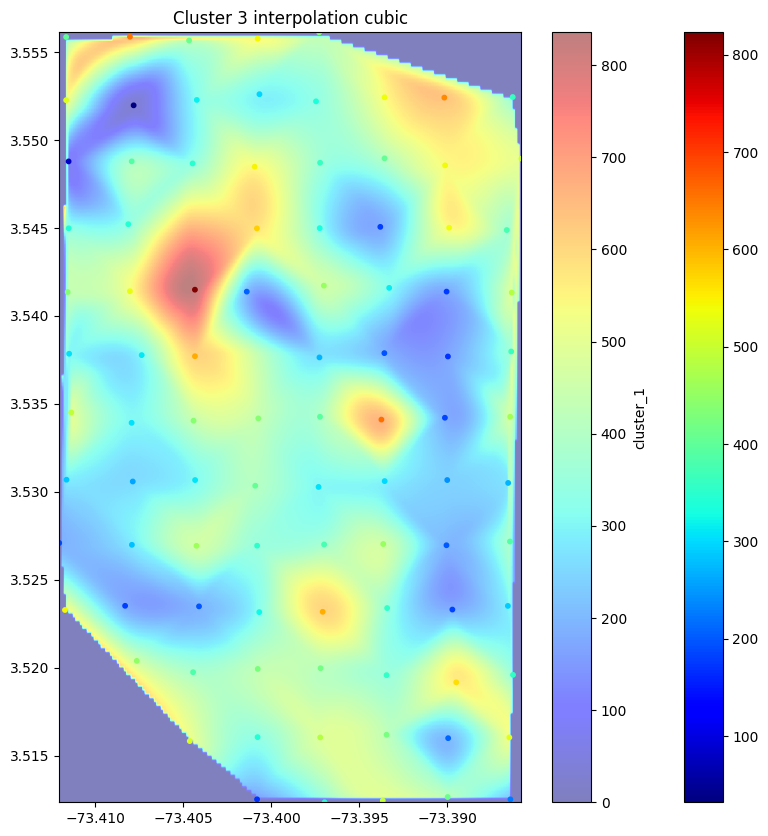

In [217]:
%matplotlib inline
resolution = 200

# Crea una cuadrícula regular para la interpolación
x_min, x_max = recorders_clusters['longitud_IG'].min(), recorders_clusters['longitud_IG'].max()
y_min, y_max = recorders_clusters['latitude_IG'].min(), recorders_clusters['latitude_IG'].max()
x_grid = np.linspace(x_min, x_max, resolution)
y_grid = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x_grid, y_grid)

# Realiza la interpolación utilizando griddata
Z3 = griddata((recorders_clusters['longitud_IG'], recorders_clusters['latitude_IG']), recorders_clusters['cluster_0'], (X, Y), method='cubic',fill_value=0)

fig, ax = plt.subplots(figsize=(10, 10))

# Visualiza los puntos originales
gdf.plot(ax=ax, column='cluster_0', cmap='jet', markersize=10, legend=True)

# Visualiza la interpolación como un mapa de calor
im = ax.imshow(Z3, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='jet', alpha=0.5)
plt.colorbar(im, ax=ax, label='cluster_1')
limited_dataimg = im.get_array()

ax.set_title('Cluster 3 interpolation cubic')
plt.show()
